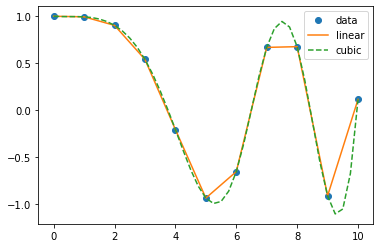

<Figure size 720x360 with 0 Axes>

41


In [1]:
import numpy as np
from scipy.interpolate import interp1d


x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')


xnew = np.linspace(0, 10, num=41, endpoint=True)
import matplotlib.pyplot as plt
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.figure(figsize=(10,5))
plt.show()

print(len(xnew))


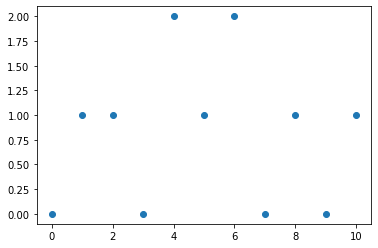

In [2]:
a = np.linspace(0,10,num=11, endpoint=True)
b = np.array([0,1,1,0,2,1,2,0,1,0,1])

plt.plot(a,b,"o")

In [3]:
from scipy import signal
%matplotlib widget

plt.plot(a, signal.square(b), "o")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
from scipy.interpolate import interp1d

x = np.linspace(0, 10, num=11, endpoint=True)
y = np.array([0,1,1,0,2,1,2,0,1,0,1])

f1 = interp1d(x, y, kind='nearest')
#f2 = interp1d(x, y, kind='previous')
#f3 = interp1d(x, y, kind='next')


xnew = np.linspace(0, 10, num=1001, endpoint=True)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(x, y, 'o')
plt.plot(xnew, f1(xnew), '-')
plt.legend(['data', 'nearest', 'previous', 'next'], loc='best')
plt.show()



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [6]:
a = np.linspace(-1, 1, num=100, endpoint= True)
len(a)

100

In [7]:
import numpy as np
import matplotlib.gridspec
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed, IntSlider, HBox, Layout, Output, VBox
import ipywidgets as widgets
from scipy import signal
from scipy.interpolate import interp1d

%matplotlib widget

In [36]:
class Interpolation():
    
    def __init__(self):
        self.out = Output(layout={'width': '980px', 'height': '500px'})
        self.axs = []
        
        
        # Interpolation function type
        self.interp_funct_types = {'rect':0, 'tri':1, 'quadratic spline':2, 'cubic spline':3, 'sinc':4}
        
        #self.funct returns the string of above that is chosen. I'll use it later for the type of interpolation
        self.funct = list(self.interp_funct_types.keys())[0]
        self.funct_idx = self.interp_funct_types[self.funct]
        
        #Here I define the array to draw the interpolating function
        self.interp_f_x = np.linspace(-1,1,num=201, endpoint=True)
        self.interp_f_y = np.zeros(201)
        #self.interp_f_y = np.cos(self.interp_f_y)
        
        # Dropdown menu to select interpolation function type 
        self.funct_menu = widgets.Dropdown(options=self.interp_funct_types.keys(), value=self.funct, 
                                            description="Choisir fonction d'interpolation:", layout=Layout(width='max-content'))
        self.funct_menu.observe(self.menu_callback, names='value')
        
        #self.x_funct = np.linspace(0, 10, num= 1000, endpoint=True)
        #self.y_funct = np.sin(self.x_funct)
        self.x = np.linspace(0, 20, num=201, endpoint=True)
        self.y = np.sin(self.x)
        self.x_val = np.linspace(0, 20, num=21, endpoint=True)
        self.y_val = np.sin(self.x_val)
        self.x_interp = np.linspace(0, 20, num=201, endpoint=True)
        self.y_interp = np.zeros(201)
        #self.f = interp1d(self.x, self.y, kind='nearest')
        #self.y_interp = self.f(self.x_interp)
        
        #For the interpolation function
        #self.functx = np.linspace(-1, 1, num=100, endpoint= True)
        #self.functy = np.full(shape=100, fill_value=1, dtype=np.int)
        
        self.init_figure()
        #plt.show()
        
        display(VBox([self.out,]),VBox([self.funct_menu]))
        plt.tight_layout(pad=0.1, w_pad=1.0, h_pad=0.1)
        

    
    
    def init_figure(self):
        with self.out:
            self.fig = plt.figure(constrained_layout=False)
            self.gs = self.fig.add_gridspec(2,2)
    
            #Plot the interpolating function
            self.axs.append(self.fig.add_subplot(self.gs[:1, -1]))
            self.axs[0].set_title("Interpolating function")
            self.axs[0].set_yticks([1e-4], minor=True)
            self.axs[0].yaxis.grid(True, which='minor',
                                   color='black', linewidth='0.5')
            self.axs[0].set_xticks([1e-4], minor=True)
            self.axs[0].xaxis.grid(True, which='minor',
                                   color='black', linewidth='0.5')
            self.axs[0].set_xlabel("t[s]")
            position = [-2, -1, 0, 1, 2]
            self.axs[0].set_xticks(position)
            #self.axs[0].plot(self.interp_f_x, self.interp_f_y, color='blue', linewidth=0.2)
            self.update_interp_f(init=True)
            #Plot the signal interpolated
           
            self.axs.append(self.fig.add_subplot(self.gs[1,:]))
            self.axs[1].set_title("Interpolation")
            self.axs[1].plot(self.x, self.y, '--')
            self.axs[1].plot(self.x_interp, self.interpolation(), '-')
            self.axs[1].plot(self.x_val, self.y_val, 'or')
        
    def interpolation(self):
        if(self.funct_idx==0):
            f = interp1d(self.x_val, self.y_val, kind="nearest")
            return f(self.x_interp)
        if(self.funct_idx==1): 
            f = interp1d(self.x_val, self.y_val, kind="linear")
            return f(self.x_interp)
        if(self.funct_idx==2): 
            f = interp1d(self.x_val, self.y_val, kind="quadratic")
            return f(self.x_interp)
        if(self.funct_idx==3): 
            f = interp1d(self.x_val, self.y_val, kind="cubic")
            return f(self.x_interp)
        
    
    def menu_callback(self, value):
        self.funct = value['new']
        self.funct_idx = self.interp_funct_types[self.funct]
        self.update_interp_f()
        self.axs[1].lines[1].set_data(self.x_interp, self.interpolation())
        
     
        #self.update_filter()
        
    #Definition of the rect function
    def rect(val):
        return np.where(np.abs(val)<=0.5, 1, 0)
    
    #Definition of the linear spline function
    def tri(self,x):
        if(x>=-1. and x<0.): return(x+1.)
        elif(x>=0. and x<=1.): return(-x+1.)
        else: return 0.
        
    def quadratic_spline(self,x):
        return x**2
            
    def cubic_spline(self,x):
        return x**3
    
    def sinc(self, x):
        return np.sinc(x)
    
    #Function to update the interpolation function, so it changes the interpolation function plot and the
    #interpolation plot
    def update_interp_f(self, init=False):
       
        if(self.funct_idx==0):
            y = np.where(np.abs(self.interp_f_x)<=0.5, 1, 0)
        
        if(self.funct_idx==1):
            y = np.where(self.interp_f_x <=0, self.interp_f_x+1, 1-self.interp_f_x)
            
        if(self.funct_idx==2):
            y = list(map(self.quadratic_spline,self.interp_f_x))
            
        if(self.funct_idx==3):
            y = list(map(self.cubic_spline,self.interp_f_x))
            
        if(self.funct_idx==4):
            y = list(map(self.sinc,self.interp_f_x))
        if init:
            self.axs[0].plot(self.interp_f_x, y, color='blue', linewidth=0.5)
        else:
            self.axs[0].lines[0].set_data(self.interp_f_x, y)
        
            
        
        
        

In [37]:
plt.close("all")
interp = Interpolation()

In [26]:
interp.axs[0].lines[0].set_data(np.linspace(-1, 1, 201), np.ones(201)*0.5)

In [ ]:
fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(2, 2)
f3_ax1 = fig3.add_subplot(gs[0, :])
f3_ax1.set_title('gs[0, :]')
f3_ax2 = fig3.add_subplot(gs[1, :-1])
f3_ax2.set_title('gs[1, :-1]')
f3_ax3 = fig3.add_subplot(gs[1:, -1])
f3_ax3.set_title('gs[1:, -1]')


In [ ]:
def tri(x):
    if(x>=-1. and x<0.): return(x+1.)
    elif(x>=0. and x<=1.): return(-x+1.)
    else: return 0.

In [ ]:
interp_f_x = np.linspace(-2,2,num=205, endpoint=True)
interp_f_y = np.zeros(205)

In [ ]:
interp_f_y=np.array(list(map(tri,interp_f_x)))

In [ ]:
interp_f_y